In [1]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EZ-LQXHjSztIrv5ayecz_nUBdHRni8ko4p_vCS1zypkhOw?download=1 -O CelebA_HQ_face_gender_dataset.zip
!unzip CelebA_HQ_face_gender_dataset.zip -d ./CelebA_HQ_face_gender_dataset

# ALEXNET

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [3]:
# Transforms untuk preprocessing data training
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar menjadi 224x224 (ukuran standar untuk AlexNet/ResNet)
    transforms.RandomHorizontalFlip(),           # Augmentasi data dengan melakukan flip horizontal secara acak
    transforms.ToTensor(),                       # Konversi gambar ke tensor (PyTorch bekerja dengan tensor)
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi nilai piksel menggunakan mean dan std yang sama dengan
                     [0.229, 0.224, 0.225])      # model pre-trained ImageNet (penting agar hasil model pre-trained optimal)
])

# Transforms untuk preprocessing data testing
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar menjadi 224x224 (tanpa augmentasi karena testing)
    transforms.ToTensor(),                       # Konversi gambar ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi dengan mean dan std dari dataset ImageNet
                     [0.229, 0.224, 0.225])
])

# Path ke dataset CelebA_HQ_face_gender_dataset (direktori berisi data training dan testing)
data_dir = './CelebA_HQ_face_gender_dataset'

# Buat dataset training dengan augmentasi dan preprocessing yang telah didefinisikan di atas
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)

# Buat dataset testing dengan preprocessing tanpa augmentasi
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

# Buat DataLoader untuk training dengan batch_size 16, shuffle=True (acak batch tiap epoch), dan 2 worker untuk loading data
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Buat DataLoader untuk testing dengan batch_size 16, shuffle=True (acak batch), dan 2 worker
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

# ukuran dataset training
print('Train dataset size:', len(train_dataset))

# ukuran dataset testing
print('Test dataset size:', len(test_dataset))

# Mendapatkan nama kelas dari dataset (misalnya, ['male', 'female'] untuk klasifikasi gender)
class_names = train_dataset.classes
print('Class names:', class_names)


Train dataset size: 23999
Test dataset size: 6001
Class names: ['female', 'male']


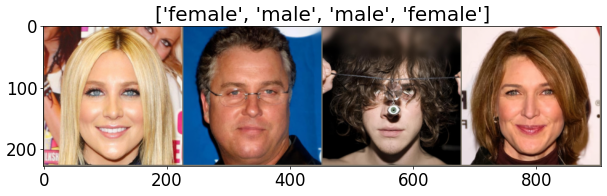

In [4]:
# Mengatur ukuran dan resolusi dari gambar yang akan ditampilkan
plt.rcParams['figure.figsize'] = [12, 8]  # Ukuran figure (12 x 8 inci)
plt.rcParams['figure.dpi'] = 60           # DPI (dots per inch) untuk resolusi gambar
plt.rcParams.update({'font.size': 20})     # Mengatur ukuran font menjadi 20

# Fungsi untuk menampilkan gambar (imshow)
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))  # Mengubah tensor dari PyTorch ke numpy array dan menukar dimensi untuk ditampilkan
    # Membalik normalisasi pada gambar agar kembali ke nilai aslinya (undo normalization)
    mean = np.array([0.485, 0.456, 0.406])      # Mean dari normalisasi yang dipakai saat preprocessing
    std = np.array([0.229, 0.224, 0.225])       # Standar deviasi dari normalisasi
    input = std * input + mean                  # Kembalikan gambar ke rentang nilai aslinya
    input = np.clip(input, 0, 1)                # Potong nilai agar tetap berada di antara 0 dan 1 (untuk menyesuaikan batas piksel)
    # Menampilkan gambar menggunakan matplotlib
    plt.imshow(input)
    plt.title(title)                            # Beri judul pada gambar
    plt.show()                                  # Tampilkan gambar

# Mengambil satu batch dari data training
iterator = iter(train_dataloader)  # Membuat iterator dari train_dataloader

# Visualisasi satu batch dari gambar training
inputs, classes = next(iterator)   # Mengambil batch pertama dari iterator (gambar dan label kelas)
out = torchvision.utils.make_grid(inputs[:4])  # Membuat grid dari 4 gambar pertama dalam batch
imshow(out, title=[class_names[x] for x in classes[:4]])  # Menampilkan gambar dengan label kelas yang sesuai


In [5]:
# Menginisialisasi model AlexNet dengan pre-trained weights
model = models.alexnet(pretrained=True)

# Mengambil jumlah fitur input dari layer terakhir (classifier[6] adalah fully connected layer terakhir)
num_features = model.classifier[6].in_features

# Mengganti layer fully connected terakhir dengan layer baru untuk klasifikasi biner
# nn.Linear(num_features, 2) artinya kita mengganti layer dengan jumlah output 2 (klasifikasi biner)
model.classifier[6] = nn.Linear(num_features, 2)  # binary classification (num_of_class == 2)

# Memindahkan model ke device (GPU/CPU tergantung setting)
model = model.to(device)

# Mendefinisikan loss function. CrossEntropyLoss digunakan untuk klasifikasi multi-kelas, termasuk biner
criterion = nn.CrossEntropyLoss()

# Menggunakan optimizer SGD (Stochastic Gradient Descent) dengan learning rate 0.001 dan momentum 0.9
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 154MB/s]


In [6]:
# Jumlah epoch untuk proses training
num_epochs = 5

# Menyimpan waktu mulai training
start_time = time.time()

# Loop untuk setiap epoch
for epoch in range(num_epochs):
    """ Training Phase """
    model.train()  # Mengatur model ke mode training, memungkinkan backpropagation dan update weight

    running_loss = 0.  # Menyimpan akumulasi loss dalam satu epoch
    running_corrects = 0  # Menyimpan jumlah prediksi yang benar dalam satu epoch

    # Loop untuk setiap batch dari train_dataloader
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)  # Memindahkan input (gambar) ke GPU (jika ada)
        labels = labels.to(device)  # Memindahkan label ke GPU (jika ada)

        # Forward pass: hitung output dari model
        optimizer.zero_grad()  # Reset gradient agar tidak terakumulasi
        outputs = model(inputs)  # Mendapatkan output dari model
        _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi dengan nilai terbesar (probabilitas tertinggi)
        loss = criterion(outputs, labels)  # Menghitung loss antara prediksi dan label sebenarnya

        # Backpropagation dan update parameter (weight)
        loss.backward()  # Hitung gradien melalui backpropagation
        optimizer.step()  # Update weight model menggunakan gradien

        # Mengakumulasi total loss dan correct predictions
        running_loss += loss.item() * inputs.size(0)  # Total loss dikali jumlah sample di batch ini
        running_corrects += torch.sum(preds == labels.data)  # Jumlah prediksi yang benar

    # Hitung rata-rata loss dan akurasi untuk satu epoch
    epoch_loss = running_loss / len(train_dataset)  # Rata-rata loss
    epoch_acc = running_corrects / len(train_dataset) * 100.  # Akurasi dalam persentase
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()  # Mengatur model ke mode evaluasi (tanpa update weight dan disable dropout)

    with torch.no_grad():  # Non-aktifkan gradient computation selama evaluasi (hemat memori & waktu)
        running_loss = 0.
        running_corrects = 0

        # Loop untuk setiap batch dari test_dataloader
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)  # Memindahkan input (gambar) ke GPU
            labels = labels.to(device)  # Memindahkan label ke GPU

            # Forward pass: hitung output dari model tanpa backpropagation
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi
            loss = criterion(outputs, labels)  # Hitung loss

            # Akumulasi total loss dan correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Hitung rata-rata loss dan akurasi untuk test set
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))


[Train #0] Loss: 0.1269 Acc: 95.1873% Time: 270.2573s
[Test #0] Loss: 0.1223 Acc: 95.1508% Time: 336.7920s
[Train #1] Loss: 0.0649 Acc: 97.6666% Time: 607.2941s
[Test #1] Loss: 0.0741 Acc: 97.2171% Time: 672.9987s
[Train #2] Loss: 0.0497 Acc: 98.1666% Time: 942.0401s
[Test #2] Loss: 0.0616 Acc: 97.7004% Time: 1008.5161s
[Train #3] Loss: 0.0404 Acc: 98.4958% Time: 1279.8077s
[Test #3] Loss: 0.0611 Acc: 97.9170% Time: 1344.0593s
[Train #4] Loss: 0.0347 Acc: 98.7208% Time: 1610.9498s
[Test #4] Loss: 0.0565 Acc: 98.0337% Time: 1677.7971s


In [7]:
save_path = 'face_gender_classification_transfer_learning_with_Alexnet.pth'  # Tentukan path dan nama file untuk menyimpan model
torch.save(model.state_dict(), save_path)  # Simpan state_dict model (berisi bobot dan bias) ke file .pth


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-8-7f25a0682530>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details)

Number of Predictions: 6001
Number of True Labels: 6001


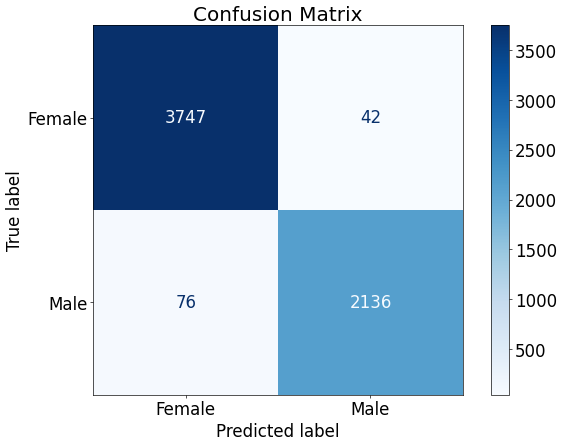

In [8]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn as nn  # Make sure to import nn for defining the classifier

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load model
# Initialize AlexNet model with pre-trained weights
model = models.alexnet(pretrained=True)

# Modify the classifier for binary classification
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)  # Set the output layer for binary classification

# Load the state dict, ensure the state dict corresponds to the modified model
model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_Alexnet.pth'), strict=False)
model.eval()
model = model.to(device)

# Initialize lists for predictions and labels
all_preds = []
all_labels = []

# Path to the test dataset
test_female_folder = 'CelebA_HQ_face_gender_dataset/test/female'
test_male_folder = 'CelebA_HQ_face_gender_dataset/test/male'

# Load female images
for image_name in os.listdir(test_female_folder):
    image_path = os.path.join(test_female_folder, image_name)
    image = Image.open(image_path).convert('RGB')  # Ensure image is RGB
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.item())
        all_labels.append(0)  # 0 for Female

# Load male images
for image_name in os.listdir(test_male_folder):
    image_path = os.path.join(test_male_folder, image_name)
    image = Image.open(image_path).convert('RGB')  # Ensure image is RGB
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.item())
        all_labels.append(1)  # 1 for Male

# Ensure all_preds and all_labels have the same length
print(f'Number of Predictions: {len(all_preds)}')
print(f'Number of True Labels: {len(all_labels)}')

# Calculate and display confusion matrix if lengths match
if len(all_preds) == len(all_labels):
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    class_names = ['Female', 'Male']  # Adjust class names for clarity
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Error: The number of predictions does not match the number of true labels.")


In [9]:
image_path = 'sri.jpg'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-10-da1c042ce36c>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

Predicted: Female


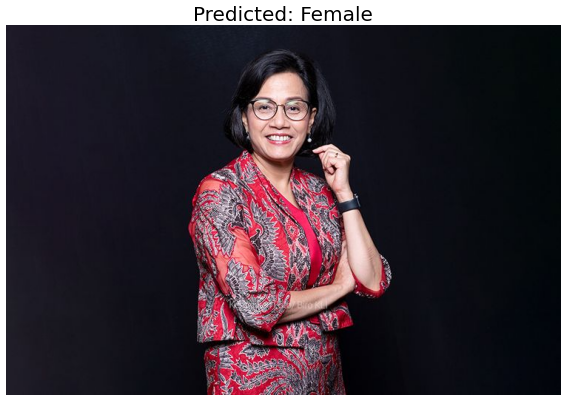

In [10]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),               # Resize the image to 224x224
    transforms.ToTensor(),                        # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalize (mean & std from ImageNet)
                         [0.229, 0.224, 0.225])
])

try:
    # Load image from file
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB mode

    # Preprocess the image
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Move image to device (GPU/CPU)
    image_tensor = image_tensor.to(device)

    # Load the trained model
    model = models.alexnet(pretrained=True)  # Initialize AlexNet model
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, 2)  # Binary classification (2 classes)
    model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_Alexnet.pth'), strict=False)  # Load weights
    model = model.to(device)  # Move model to device
    model.eval()  # Set model to evaluation mode

    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)  # Forward pass to get predictions
        _, preds = torch.max(outputs, 1)  # Get predicted class with the highest score

    # Display results
    class_names = ['Male', 'Female']  # Example for gender classification
    predicted_label = class_names[preds.item()]
    print('Predicted:', predicted_label)

    # Plot the image with the prediction
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")


# GOOGLENET

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [12]:
# Transforms untuk preprocessing data training
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar menjadi 224x224 (ukuran standar untuk AlexNet/ResNet)
    transforms.RandomHorizontalFlip(),           # Augmentasi data dengan melakukan flip horizontal secara acak
    transforms.ToTensor(),                       # Konversi gambar ke tensor (PyTorch bekerja dengan tensor)
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi nilai piksel menggunakan mean dan std yang sama dengan
                     [0.229, 0.224, 0.225])      # model pre-trained ImageNet (penting agar hasil model pre-trained optimal)
])

# Transforms untuk preprocessing data testing
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar menjadi 224x224 (tanpa augmentasi karena testing)
    transforms.ToTensor(),                       # Konversi gambar ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi dengan mean dan std dari dataset ImageNet
                     [0.229, 0.224, 0.225])
])

# Path ke dataset CelebA_HQ_face_gender_dataset (direktori berisi data training dan testing)
data_dir = './CelebA_HQ_face_gender_dataset'

# Buat dataset training dengan augmentasi dan preprocessing yang telah didefinisikan di atas
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)

# Buat dataset testing dengan preprocessing tanpa augmentasi
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

# Buat DataLoader untuk training dengan batch_size 16, shuffle=True (acak batch tiap epoch), dan 2 worker untuk loading data
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Buat DataLoader untuk testing dengan batch_size 16, shuffle=True (acak batch), dan 2 worker
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

# ukuran dataset training
print('Train dataset size:', len(train_dataset))

# ukuran dataset testing
print('Test dataset size:', len(test_dataset))

# Mendapatkan nama kelas dari dataset (misalnya, ['male', 'female'] untuk klasifikasi gender)
class_names = train_dataset.classes
print('Class names:', class_names)


Train dataset size: 23999
Test dataset size: 6001
Class names: ['female', 'male']


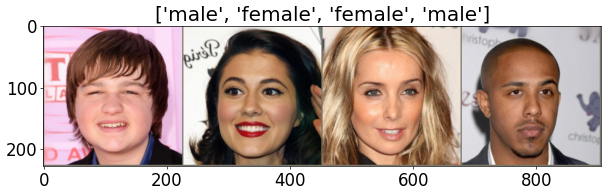

In [13]:
# Mengatur ukuran dan resolusi dari gambar yang akan ditampilkan
plt.rcParams['figure.figsize'] = [12, 8]  # Ukuran figure (12 x 8 inci)
plt.rcParams['figure.dpi'] = 60           # DPI (dots per inch) untuk resolusi gambar
plt.rcParams.update({'font.size': 20})     # Mengatur ukuran font menjadi 20

# Fungsi untuk menampilkan gambar (imshow)
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))  # Mengubah tensor dari PyTorch ke numpy array dan menukar dimensi untuk ditampilkan
    # Membalik normalisasi pada gambar agar kembali ke nilai aslinya (undo normalization)
    mean = np.array([0.485, 0.456, 0.406])      # Mean dari normalisasi yang dipakai saat preprocessing
    std = np.array([0.229, 0.224, 0.225])       # Standar deviasi dari normalisasi
    input = std * input + mean                  # Kembalikan gambar ke rentang nilai aslinya
    input = np.clip(input, 0, 1)                # Potong nilai agar tetap berada di antara 0 dan 1 (untuk menyesuaikan batas piksel)
    # Menampilkan gambar menggunakan matplotlib
    plt.imshow(input)
    plt.title(title)                            # Beri judul pada gambar
    plt.show()                                  # Tampilkan gambar

# Mengambil satu batch dari data training
iterator = iter(train_dataloader)  # Membuat iterator dari train_dataloader

# Visualisasi satu batch dari gambar training
inputs, classes = next(iterator)   # Mengambil batch pertama dari iterator (gambar dan label kelas)
out = torchvision.utils.make_grid(inputs[:4])  # Membuat grid dari 4 gambar pertama dalam batch
imshow(out, title=[class_names[x] for x in classes[:4]])  # Menampilkan gambar dengan label kelas yang sesuai


In [14]:
# Menginisialisasi model GoogleNet dengan pre-trained weights
model = models.googlenet(pretrained=True)

# Mengambil jumlah fitur input dari layer terakhir (classifier[6] adalah fully connected layer terakhir)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Memindahkan model ke device (GPU/CPU tergantung setting)
model = model.to(device)

# Mendefinisikan loss function. CrossEntropyLoss digunakan untuk klasifikasi multi-kelas, termasuk biner
criterion = nn.CrossEntropyLoss()

# Menggunakan optimizer SGD (Stochastic Gradient Descent) dengan learning rate 0.001 dan momentum 0.9
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 174MB/s]


In [15]:
# Jumlah epoch untuk proses training
num_epochs = 5

# Menyimpan waktu mulai training
start_time = time.time()

# Loop untuk setiap epoch
for epoch in range(num_epochs):
    """ Training Phase """
    model.train()  # Mengatur model ke mode training, memungkinkan backpropagation dan update weight

    running_loss = 0.  # Menyimpan akumulasi loss dalam satu epoch
    running_corrects = 0  # Menyimpan jumlah prediksi yang benar dalam satu epoch

    # Loop untuk setiap batch dari train_dataloader
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)  # Memindahkan input (gambar) ke GPU (jika ada)
        labels = labels.to(device)  # Memindahkan label ke GPU (jika ada)

        # Forward pass: hitung output dari model
        optimizer.zero_grad()  # Reset gradient agar tidak terakumulasi
        outputs = model(inputs)  # Mendapatkan output dari model
        _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi dengan nilai terbesar (probabilitas tertinggi)
        loss = criterion(outputs, labels)  # Menghitung loss antara prediksi dan label sebenarnya

        # Backpropagation dan update parameter (weight)
        loss.backward()  # Hitung gradien melalui backpropagation
        optimizer.step()  # Update weight model menggunakan gradien

        # Mengakumulasi total loss dan correct predictions
        running_loss += loss.item() * inputs.size(0)  # Total loss dikali jumlah sample di batch ini
        running_corrects += torch.sum(preds == labels.data)  # Jumlah prediksi yang benar

    # Hitung rata-rata loss dan akurasi untuk satu epoch
    epoch_loss = running_loss / len(train_dataset)  # Rata-rata loss
    epoch_acc = running_corrects / len(train_dataset) * 100.  # Akurasi dalam persentase
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()  # Mengatur model ke mode evaluasi (tanpa update weight dan disable dropout)

    with torch.no_grad():  # Non-aktifkan gradient computation selama evaluasi (hemat memori & waktu)
        running_loss = 0.
        running_corrects = 0

        # Loop untuk setiap batch dari test_dataloader
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)  # Memindahkan input (gambar) ke GPU
            labels = labels.to(device)  # Memindahkan label ke GPU

            # Forward pass: hitung output dari model tanpa backpropagation
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi
            loss = criterion(outputs, labels)  # Hitung loss

            # Akumulasi total loss dan correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Hitung rata-rata loss dan akurasi untuk test set
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))


[Train #0] Loss: 0.1255 Acc: 95.0873% Time: 304.5695s
[Test #0] Loss: 0.0594 Acc: 97.8504% Time: 376.2776s
[Train #1] Loss: 0.0546 Acc: 98.1999% Time: 685.0056s
[Test #1] Loss: 0.0530 Acc: 98.1503% Time: 757.2913s
[Train #2] Loss: 0.0389 Acc: 98.7041% Time: 1067.6936s
[Test #2] Loss: 0.0556 Acc: 98.1836% Time: 1137.0313s
[Train #3] Loss: 0.0247 Acc: 99.2583% Time: 1450.2351s
[Test #3] Loss: 0.0680 Acc: 98.1503% Time: 1523.2198s
[Train #4] Loss: 0.0200 Acc: 99.3333% Time: 1824.1704s
[Test #4] Loss: 0.0598 Acc: 98.2336% Time: 1893.8565s


In [16]:
save_path = 'face_gender_classification_transfer_learning_with_GoogleNET.pth'  # Tentukan path dan nama file untuk menyimpan model
torch.save(model.state_dict(), save_path)  # Simpan state_dict model (berisi bobot dan bias) ke file .pth


Number of Predictions: 6001
Number of True Labels: 6001


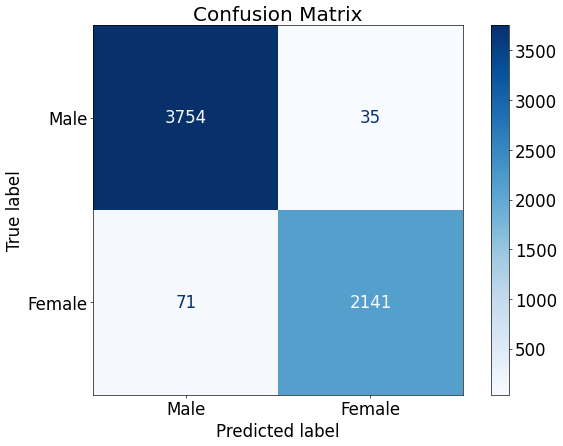

In [17]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load model
model = models.googlenet(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_GoogleNET.pth', weights_only=True))
model.eval()
model = model.to(device)

# Initialize lists for predictions and labels
all_preds = []
all_labels = []

# Path to the test dataset
test_female_folder = 'CelebA_HQ_face_gender_dataset/test/female'
test_male_folder = 'CelebA_HQ_face_gender_dataset/test/male'

# Load female images
for image_name in os.listdir(test_female_folder):
    image_path = os.path.join(test_female_folder, image_name)
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.item())
        all_labels.append(0)  # 0 for Female

# Load male images
for image_name in os.listdir(test_male_folder):
    image_path = os.path.join(test_male_folder, image_name)
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.item())
        all_labels.append(1)  # 1 for Male

# Ensure all_preds and all_labels have the same length
print(f'Number of Predictions: {len(all_preds)}')
print(f'Number of True Labels: {len(all_labels)}')

# Calculate and display confusion matrix if lengths match
if len(all_preds) == len(all_labels):
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    class_names = ['Male', 'Female']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Error: The number of predictions does not match the number of true labels.")


In [18]:
image_path = 'sri.jpg'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-19-9c6512484cf1>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more det

Predicted: Female


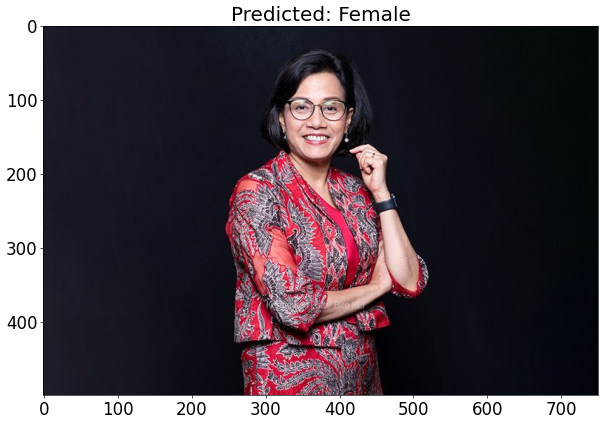

[Test #4] Loss: 0.0598 Acc: 98.2336% Time: 2013.2879s


In [19]:
# Preprocessing gambar, sesuai dengan transformasi yang dipakai saat training
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar ke 224x224
    transforms.ToTensor(),                       # Konversi gambar ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi (mean & std dari ImageNet)
                         [0.229, 0.224, 0.225])
])

# Muat gambar dari file
image = Image.open(image_path)

# Preprocess gambar
image_tensor = preprocess(image).unsqueeze(0)  # Menambahkan batch dimension di depan

# Pindahkan gambar ke device (GPU/CPU)
image_tensor = image_tensor.to(device)

# Menginisialisasi model GoogleNet dengan pre-trained weights
model = models.googlenet(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_GoogleNET.pth'))  # Muat bobot
model = model.to(device)  # Pindahkan model ke device
model.eval()  # Set model ke mode evaluasi

with torch.no_grad():
    outputs = model(image_tensor)  # Forward pass untuk mendapatkan prediksi
    _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi kelas dengan nilai tertinggi

# Tampilkan hasil prediksi
class_names = ['Male', 'Female']  # Misalnya untuk klasifikasi gender
print('Predicted:', class_names[preds.item()])

# Tampilkan hasil prediksi
class_names = ['Male', 'Female']
predicted_label = class_names[preds.item()]
# Plot gambar dan hasil prediksi
plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.show()
epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

# VGG

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
from PIL import Image
#from google.colab import drive
#drive.mount('/content/drive')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [21]:
# Transforms untuk preprocessing data training
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar menjadi 224x224 (ukuran standar untuk AlexNet/ResNet)
    transforms.RandomHorizontalFlip(),           # Augmentasi data dengan melakukan flip horizontal secara acak
    transforms.ToTensor(),                       # Konversi gambar ke tensor (PyTorch bekerja dengan tensor)
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi nilai piksel menggunakan mean dan std yang sama dengan
                     [0.229, 0.224, 0.225])      # model pre-trained ImageNet (penting agar hasil model pre-trained optimal)
])

# Transforms untuk preprocessing data testing
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar menjadi 224x224 (tanpa augmentasi karena testing)
    transforms.ToTensor(),                       # Konversi gambar ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi dengan mean dan std dari dataset ImageNet
                     [0.229, 0.224, 0.225])
])

# Path ke dataset CelebA_HQ_face_gender_dataset (direktori berisi data training dan testing)
data_dir = './CelebA_HQ_face_gender_dataset'

# Buat dataset training dengan augmentasi dan preprocessing yang telah didefinisikan di atas
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)

# Buat dataset testing dengan preprocessing tanpa augmentasi
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

# Buat DataLoader untuk training dengan batch_size 16, shuffle=True (acak batch tiap epoch), dan 2 worker untuk loading data
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Buat DataLoader untuk testing dengan batch_size 16, shuffle=True (acak batch), dan 2 worker
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

# ukuran dataset training
print('Train dataset size:', len(train_dataset))

# ukuran dataset testing
print('Test dataset size:', len(test_dataset))

# Mendapatkan nama kelas dari dataset (misalnya, ['male', 'female'] untuk klasifikasi gender)
class_names = train_dataset.classes
print('Class names:', class_names)


Train dataset size: 23999
Test dataset size: 6001
Class names: ['female', 'male']


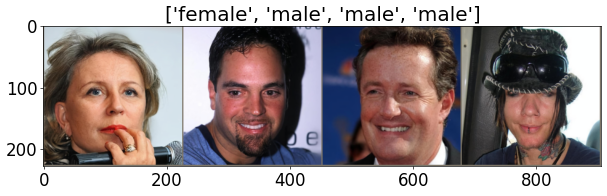

In [22]:
# Mengatur ukuran dan resolusi dari gambar yang akan ditampilkan
plt.rcParams['figure.figsize'] = [12, 8]  # Ukuran figure (12 x 8 inci)
plt.rcParams['figure.dpi'] = 60           # DPI (dots per inch) untuk resolusi gambar
plt.rcParams.update({'font.size': 20})     # Mengatur ukuran font menjadi 20

# Fungsi untuk menampilkan gambar (imshow)
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))  # Mengubah tensor dari PyTorch ke numpy array dan menukar dimensi untuk ditampilkan
    # Membalik normalisasi pada gambar agar kembali ke nilai aslinya (undo normalization)
    mean = np.array([0.485, 0.456, 0.406])      # Mean dari normalisasi yang dipakai saat preprocessing
    std = np.array([0.229, 0.224, 0.225])       # Standar deviasi dari normalisasi
    input = std * input + mean                  # Kembalikan gambar ke rentang nilai aslinya
    input = np.clip(input, 0, 1)                # Potong nilai agar tetap berada di antara 0 dan 1 (untuk menyesuaikan batas piksel)
    # Menampilkan gambar menggunakan matplotlib
    plt.imshow(input)
    plt.title(title)                            # Beri judul pada gambar
    plt.show()                                  # Tampilkan gambar

# Mengambil satu batch dari data training
iterator = iter(train_dataloader)  # Membuat iterator dari train_dataloader

# Visualisasi satu batch dari gambar training
inputs, classes = next(iterator)   # Mengambil batch pertama dari iterator (gambar dan label kelas)
out = torchvision.utils.make_grid(inputs[:4])  # Membuat grid dari 4 gambar pertama dalam batch
imshow(out, title=[class_names[x] for x in classes[:4]])  # Menampilkan gambar dengan label kelas yang sesuai


In [23]:

# Menginisialisasi model VGG16 dengan pre-trained weights
model = models.vgg16(pretrained=True)

# Mengambil jumlah fitur input dari layer fully connected terakhir (classifier[6])
num_features = model.classifier[6].in_features

# Mengganti layer fully connected terakhir dengan layer baru untuk klasifikasi biner
# nn.Linear(num_features, 2) artinya kita mengganti layer dengan jumlah output 2 (klasifikasi biner)
model.classifier[6] = nn.Linear(num_features, 2)  # binary classification (num_of_class == 2)

# Memindahkan model ke device (GPU/CPU tergantung setting)
model = model.to(device)

# Mendefinisikan loss function. CrossEntropyLoss digunakan untuk klasifikasi multi-kelas, termasuk biner
criterion = nn.CrossEntropyLoss()

# Menggunakan optimizer SGD (Stochastic Gradient Descent) dengan learning rate 0.001 dan momentum 0.9
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 133MB/s]


In [24]:
# Jumlah epoch untuk proses training
num_epochs = 5

# Menyimpan waktu mulai training
start_time = time.time()

# Loop untuk setiap epoch
for epoch in range(num_epochs):
    """ Training Phase """
    model.train()  # Mengatur model ke mode training, memungkinkan backpropagation dan update weight

    running_loss = 0.  # Menyimpan akumulasi loss dalam satu epoch
    running_corrects = 0  # Menyimpan jumlah prediksi yang benar dalam satu epoch

    # Loop untuk setiap batch dari train_dataloader
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)  # Memindahkan input (gambar) ke GPU (jika ada)
        labels = labels.to(device)  # Memindahkan label ke GPU (jika ada)

        # Forward pass: hitung output dari model
        optimizer.zero_grad()  # Reset gradient agar tidak terakumulasi
        outputs = model(inputs)  # Mendapatkan output dari model
        _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi dengan nilai terbesar (probabilitas tertinggi)
        loss = criterion(outputs, labels)  # Menghitung loss antara prediksi dan label sebenarnya

        # Backpropagation dan update parameter (weight)
        loss.backward()  # Hitung gradien melalui backpropagation
        optimizer.step()  # Update weight model menggunakan gradien

        # Mengakumulasi total loss dan correct predictions
        running_loss += loss.item() * inputs.size(0)  # Total loss dikali jumlah sample di batch ini
        running_corrects += torch.sum(preds == labels.data)  # Jumlah prediksi yang benar

    # Hitung rata-rata loss dan akurasi untuk satu epoch
    epoch_loss = running_loss / len(train_dataset)  # Rata-rata loss
    epoch_acc = running_corrects / len(train_dataset) * 100.  # Akurasi dalam persentase
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()  # Mengatur model ke mode evaluasi (tanpa update weight dan disable dropout)

    with torch.no_grad():  # Non-aktifkan gradient computation selama evaluasi (hemat memori & waktu)
        running_loss = 0.
        running_corrects = 0

        # Loop untuk setiap batch dari test_dataloader
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)  # Memindahkan input (gambar) ke GPU
            labels = labels.to(device)  # Memindahkan label ke GPU

            # Forward pass: hitung output dari model tanpa backpropagation
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi
            loss = criterion(outputs, labels)  # Hitung loss

            # Akumulasi total loss dan correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Hitung rata-rata loss dan akurasi untuk test set
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))


[Train #0] Loss: 0.0755 Acc: 97.1582% Time: 417.1413s
[Test #0] Loss: 0.0521 Acc: 98.2670% Time: 497.5950s
[Train #1] Loss: 0.0376 Acc: 98.6583% Time: 912.9390s
[Test #1] Loss: 0.0639 Acc: 97.6004% Time: 990.5064s
[Train #2] Loss: 0.0252 Acc: 99.0458% Time: 1403.5025s
[Test #2] Loss: 0.0485 Acc: 98.2503% Time: 1480.7817s
[Train #3] Loss: 0.0198 Acc: 99.2875% Time: 1891.2209s
[Test #3] Loss: 0.0783 Acc: 97.8670% Time: 1967.5380s
[Train #4] Loss: 0.0151 Acc: 99.5333% Time: 2385.3780s
[Test #4] Loss: 0.0572 Acc: 98.4336% Time: 2465.5706s


In [25]:
save_path = 'face_gender_classification_transfer_learning_with_VGG.pth'  # Tentukan path dan nama file untuk menyimpan model
torch.save(model.state_dict(), save_path)  # Simpan state_dict model (berisi bobot dan bias) ke file .pth


In [28]:
image_path = 'sri.jpg'

<ipython-input-29-3acc583ee2f9>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_VGG.pth

Predicted: Male


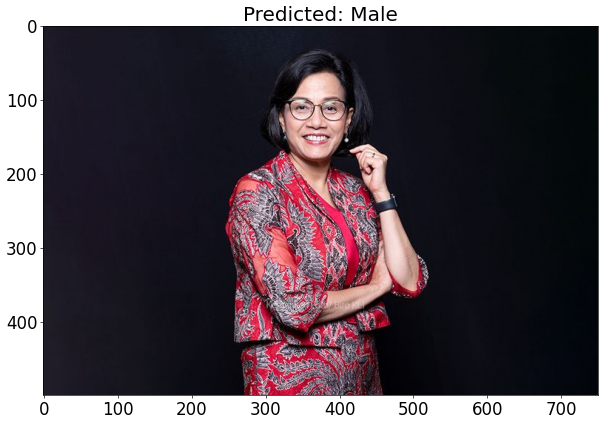

In [29]:
# Preprocessing gambar, sesuai dengan transformasi yang dipakai saat training
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar ke 224x224
    transforms.ToTensor(),                       # Konversi gambar ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi (mean & std dari ImageNet)
                         [0.229, 0.224, 0.225])
])

# Muat gambar dari file
image = Image.open(image_path)

# Preprocess gambar
image_tensor = preprocess(image).unsqueeze(0)  # Menambahkan batch dimension di depan

# Pindahkan gambar ke device (GPU/CPU)
image_tensor = image_tensor.to(device)

# Menginisialisasi model GoogleNet dengan pre-trained weights
model = models.vgg16(pretrained=True)

# Mengambil jumlah fitur input dari layer fully connected terakhir (classifier[6])
num_features = model.classifier[6].in_features

# Mengganti layer fully connected terakhir dengan layer baru untuk klasifikasi biner
# nn.Linear(num_features, 2) artinya kita mengganti layer dengan jumlah output 2 (klasifikasi biner)
model.classifier[6] = nn.Linear(num_features, 2)  # binary classification (num_of_class == 2)

# Memindahkan model ke device (GPU/CPU tergantung setting)
model = model.to(device)

model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_VGG.pth'))  # Muat bobot
model = model.to(device)  # Pindahkan model ke device
model.eval()  # Set model ke mode evaluasi

with torch.no_grad():
    outputs = model(image_tensor)  # Forward pass untuk mendapatkan prediksi
    _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi kelas dengan nilai tertinggi

# Tampilkan hasil prediksi
class_names = ['Male', 'Female']  # Misalnya untuk klasifikasi gender
print('Predicted:', class_names[preds.item()])

# Tampilkan hasil prediksi
class_names = ['Male', 'Female']
predicted_label = class_names[preds.item()]
# Plot gambar dan hasil prediksi
plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.show()

<ipython-input-30-e5258cfb8720>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_VGG.pth

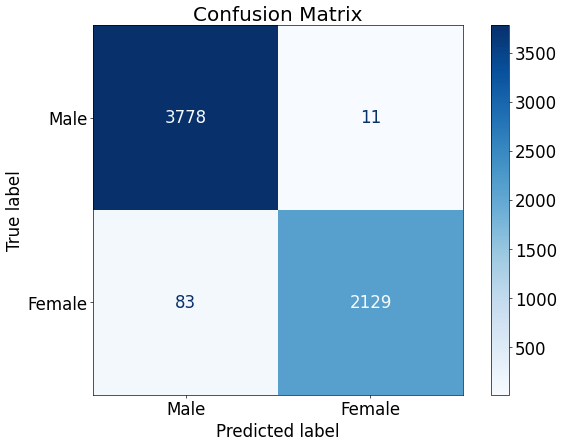

In [30]:
model = models.vgg16(pretrained=True)

# Mengambil jumlah fitur input dari layer fully connected terakhir (classifier[6])
num_features = model.classifier[6].in_features

# Mengganti layer fully connected terakhir dengan layer baru untuk klasifikasi biner
# nn.Linear(num_features, 2) artinya kita mengganti layer dengan jumlah output 2 (klasifikasi biner)
model.classifier[6] = nn.Linear(num_features, 2)  # binary classification (num_of_class == 2)

# Memindahkan model ke device (GPU/CPU tergantung setting)
model = model.to(device)

model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_VGG.pth'))  # Muat bobot
model = model.to(device)  # Pindahkan model ke device
model.eval()  # Set model ke mode evaluasi


all_preds = []
all_labels = []

# Path to the test dataset
test_female_folder = 'CelebA_HQ_face_gender_dataset/test/female'
test_male_folder = 'CelebA_HQ_face_gender_dataset/test/male'

# Load images and their corresponding labels
image_paths = []
true_labels = []

# Load female images
for image_name in os.listdir(test_female_folder):
    image_paths.append(os.path.join(test_female_folder, image_name))
    true_labels.append(0)  # 0 for Female

# Load male images
for image_name in os.listdir(test_male_folder):
    image_paths.append(os.path.join(test_male_folder, image_name))
    true_labels.append(1)  # 1 for Male

# Process each image
for image_path, true_label in zip(image_paths, true_labels):
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)  # Forward pass untuk mendapatkan prediksi
        _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi kelas dengan nilai tertinggi

    # Simpan hasil prediksi dan label asli
    all_preds.append(preds.item())
    all_labels.append(true_label)

# Hitung dan tampilkan confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])  # Sesuaikan dengan label asli
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# RESNET

In [31]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EZ-LQXHjSztIrv5ayecz_nUBdHRni8ko4p_vCS1zypkhOw?download=1 -O CelebA_HQ_face_gender_dataset.zip
!unzip CelebA_HQ_face_gender_dataset.zip -d ./CelebA_HQ_face_gender_dataset

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [33]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './CelebA_HQ_face_gender_dataset'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 23999
Test dataset size: 6001
Class names: ['female', 'male']


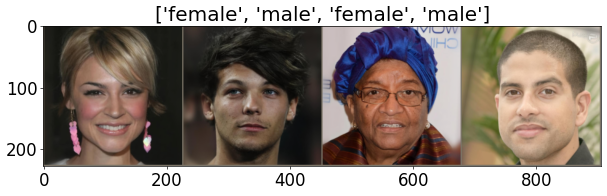

In [34]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [35]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # binary classification (num_of_class == 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


In [36]:
num_epochs = 5
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

[Train #0] Loss: 0.0898 Acc: 96.7207% Time: 300.5880s
[Test #0] Loss: 0.0567 Acc: 97.6837% Time: 370.3020s
[Train #1] Loss: 0.0437 Acc: 98.4374% Time: 656.4217s
[Test #1] Loss: 0.0525 Acc: 98.4669% Time: 726.0654s
[Train #2] Loss: 0.0286 Acc: 99.0375% Time: 1017.7287s
[Test #2] Loss: 0.0442 Acc: 98.4836% Time: 1087.3307s
[Train #3] Loss: 0.0175 Acc: 99.4500% Time: 1376.7104s
[Test #3] Loss: 0.0581 Acc: 98.4669% Time: 1443.2731s
[Train #4] Loss: 0.0116 Acc: 99.6542% Time: 1736.8377s
[Test #4] Loss: 0.0535 Acc: 98.6336% Time: 1806.4469s


In [37]:
save_path = 'face_gender_classification_transfer_learning_with_ResNet18.pth'
torch.save(model.state_dict(), save_path)

In [40]:
image_path = 'sri.jpg'

<ipython-input-41-16d58d065137>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_ResNet1

Predicted: Female


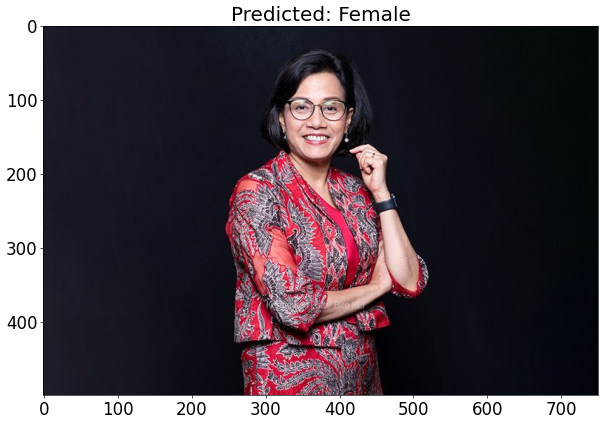

[Test #4] Loss: 0.0535 Acc: 98.6336% Time: 1819.0413s


In [41]:
# Preprocessing gambar, sesuai dengan transformasi yang dipakai saat training
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),               # Ubah ukuran gambar ke 224x224
    transforms.ToTensor(),                       # Konversi gambar ke tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi (mean & std dari ImageNet)
                         [0.229, 0.224, 0.225])
])

# Muat gambar dari file
image = Image.open(image_path)

# Preprocess gambar
image_tensor = preprocess(image).unsqueeze(0)  # Menambahkan batch dimension di depan

# Pindahkan gambar ke device (GPU/CPU)
image_tensor = image_tensor.to(device)

# Menginisialisasi model GoogleNet dengan pre-trained weights
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features  # Mendapatkan jumlah fitur dari layer fully connected (fc) terakhir

model.fc = nn.Linear(num_features, 2)  # Mengganti layer fully connected terakhir untuk binary classification (jumlah kelas = 2)

model = model.to(device)

model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_ResNet18.pth'))  # Muat bobot
model = model.to(device)  # Pindahkan model ke device
model.eval()  # Set model ke mode evaluasi

with torch.no_grad():
    outputs = model(image_tensor)  # Forward pass untuk mendapatkan prediksi
    _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi kelas dengan nilai tertinggi

# Tampilkan hasil prediksi
class_names = ['Male', 'Female']  # Misalnya untuk klasifikasi gender
print('Predicted:', class_names[preds.item()])

# Tampilkan hasil prediksi
class_names = ['Male', 'Female']
predicted_label = class_names[preds.item()]
# Plot gambar dan hasil prediksi
plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.show()
epoch_loss = running_loss / len(test_dataset)
epoch_acc = running_corrects / len(test_dataset) * 100.
print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

<ipython-input-42-03b2efd4467a>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_ResNet1

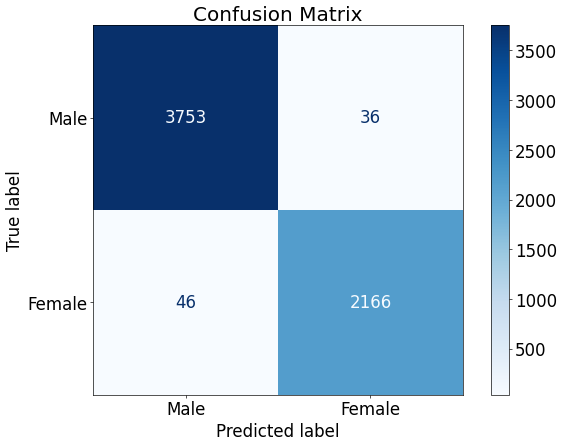

In [42]:
# Mengimpor model ResNet18 yang telah dilatih sebelumnya
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features  # Mendapatkan jumlah fitur dari layer fully connected (fc) terakhir

model.fc = nn.Linear(num_features, 2)  # Mengganti layer fully connected terakhir untuk binary classification (jumlah kelas = 2)

model = model.to(device)

model.load_state_dict(torch.load('face_gender_classification_transfer_learning_with_ResNet18.pth'))  # Muat bobot
model = model.to(device)  # Pindahkan model ke device
model.eval()  # Set model ke mode evaluasi
all_preds = []
all_labels = []

# Path to the test dataset
test_female_folder = 'CelebA_HQ_face_gender_dataset/test/female'
test_male_folder = 'CelebA_HQ_face_gender_dataset/test/male'

# Load images and their corresponding labels
image_paths = []
true_labels = []

# Load female images
for image_name in os.listdir(test_female_folder):
    image_paths.append(os.path.join(test_female_folder, image_name))
    true_labels.append(0)  # 0 for Female

# Load male images
for image_name in os.listdir(test_male_folder):
    image_paths.append(os.path.join(test_male_folder, image_name))
    true_labels.append(1)  # 1 for Male

# Process each image
for image_path, true_label in zip(image_paths, true_labels):
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)  # Forward pass untuk mendapatkan prediksi
        _, preds = torch.max(outputs, 1)  # Mendapatkan prediksi kelas dengan nilai tertinggi

    # Simpan hasil prediksi dan label asli
    all_preds.append(preds.item())
    all_labels.append(true_label)

# Hitung dan tampilkan confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])  # Sesuaikan dengan label asli
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()